# deep_5 optimal model
# deep_res resnet and big generator
# deep_res_2 resnet and small generator


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import h5py
import tqdm
import zipfile
from tqdm.notebook import tqdm_notebook
from progress.bar import IncrementalBar
import random
import pandas as pd
import time
import os
from joblib import Parallel, delayed
# tf.config.run_functions_eagerly(True)
%matplotlib inline

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:

param_names=['signal','pl_fr','real_wf','mask']


In [4]:
def norming(data,param_names=param_names,log=True):
    
    # ADD LOGARIFM FOR SIGNAL
    norm_params={}
    for i in range(data.shape[-1]):
        if (i==0 and log):
            data[:,:,:,i]=tf.math.log(data[:,:,:,i]+1)
        max_c=data[:,:,:,i].max()
        min_c=data[:,:,:,i].min()
        mean_c=data[:,:,:,i].mean()
        std_c=data[:,:,:,i].std()
        print(max_c,min_c)
        data[:,:,:,i]=(data[:,:,:,i]-min_c)/(max_c-min_c)

        norm_params[param_names[i]]=np.array([max_c,min_c])
    return norm_params
def renormin(data_not_change,norm_params,param_names=param_names,log=True):
    data=np.copy(data_not_change)
    for i in range(data.shape[-1]):
        max_c, min_c=norm_params[param_names[i]]
        data[:,:,:,i]=data[:,:,:,i]*(max_c-min_c) + min_c
        if (i==0 and log):
            data[:,:,:,i]=tf.math.exp(data[:,:,:,i])-1
        elif (i==1 or i==2):
            data[:,:,:,i]=data[:,:,:,i]*1e6
    return data

In [6]:
data=np.zeros((1,6,6,4))
with h5py.File("../mk_all_old.h5",'r') as f:
    mk_all=list(f.keys())[:-3]
    print(mk_all)
    for path_mk in mk_all:
#         print(f[path_mk]['pr-3'].keys())# вырезки центрированные около середины ливня size 6x6
#     print(f[general_name]['dt'])
        data=np.concatenate((data,f[path_mk]['pr-3']['dt'][:,:,:,3:7]))
#         print(np.array(data).shape)
#     print(f[general_name]['ev_params'][:,1])
# #     data=f['sddata']['wf_fl'][:]
#     print(f['norm_param_global_18.0_qgs3_all']['wf_fl']['mean'][:])
data=data[1:]
norm_params=norming(data)
print(norm_params)
print(data.shape)
np.random.shuffle(data)
shape=data.shape[1:]

['enbin-2.0-0.0', 'enbin0.0-0.1', 'enbin0.1-0.2', 'enbin0.2-0.3', 'enbin0.3-0.4', 'enbin0.4-0.5', 'enbin0.5-0.6', 'enbin0.6-0.7', 'enbin0.7-0.8', 'enbin0.8-0.9', 'enbin0.9-1.0', 'enbin1.0-1.1', 'enbin1.1-1.2', 'enbin1.2-1.3', 'enbin1.3-1.4', 'enbin1.4-1.5', 'enbin1.5-1.6', 'enbin1.6-1.7', 'enbin1.7-1.8', 'enbin1.8-1.9', 'enbin1.9-2.0', 'enbin2.0-2.1', 'enbin2.1-2.2', 'enbin2.2-2.3', 'enbin2.3-2.4', 'enbin2.4-2.5', 'enbin2.5-2.6', 'enbin2.6-2.7', 'enbin2.7-2.8', 'enbin2.8-2.9', 'enbin2.9-3.0', 'enbin3.0-4']
6.075288572204657 0.0
1.1907000043720473e-05 -1.270200027647661e-05
1.0000015497207642 -3.1459999263461214e-06
1.0 0.0
{'signal': array([6.07528857, 0.        ]), 'pl_fr': array([ 1.19070000e-05, -1.27020003e-05]), 'real_wf': array([ 1.00000155e+00, -3.14599993e-06]), 'mask': array([1., 0.])}
(120293, 6, 6, 4)


In [41]:
print(data[0,1])
print(data[0,2])

[[0.00000000e+00 5.16152632e-01 3.14598515e-06 0.00000000e+00]
 [0.00000000e+00 5.16152632e-01 3.14598515e-06 0.00000000e+00]
 [0.00000000e+00 5.16152632e-01 3.14598515e-06 0.00000000e+00]
 [0.00000000e+00 5.16152632e-01 3.14598515e-06 0.00000000e+00]
 [0.00000000e+00 5.16152632e-01 3.14598515e-06 0.00000000e+00]
 [0.00000000e+00 5.16152632e-01 3.14598515e-06 0.00000000e+00]]
[[0.00000000e+00 5.16152632e-01 3.14598515e-06 0.00000000e+00]
 [0.00000000e+00 5.16152632e-01 3.14598515e-06 0.00000000e+00]
 [3.20933819e-01 4.98801256e-01 3.50598346e-06 1.00000000e+00]
 [4.74875778e-01 4.61863552e-01 3.47598361e-06 1.00000000e+00]
 [9.93588617e-02 4.23869318e-01 4.67097801e-06 1.00000000e+00]
 [0.00000000e+00 5.16152632e-01 3.14598515e-06 0.00000000e+00]]


In [80]:
data[0].shape
def xy_core(data,tf_type=tf.float32):
    mask=data[:,:,:,3]
    signal=data[:,:,:,0]*mask
    x=tf.cast(tf.repeat(tf.expand_dims(tf.range(0,6),0),6,axis=0),tf_type)
    y=tf.cast(tf.repeat(tf.expand_dims(tf.range(0,6),1),6,axis=1),tf_type)
    sum_signal=tf.cast(tf.reduce_sum(signal,axis=(1,2)),tf_type)
    cm_x=tf.reduce_sum(signal*x,axis=(1,2))/sum_signal
    cm_y=tf.reduce_sum(signal*y,axis=(1,2))/sum_signal
    return tf.concat([tf.expand_dims(cm_x,1),tf.expand_dims(cm_y,1)],axis=1)
def expand_dims(vec):
    return tf.expand_dims(tf.expand_dims(vec,-1),-1)
def create_matrix(x,y,t):
    a11=expand_dims(tf.reduce_sum(x*x,axis=1))
    a12=expand_dims(tf.reduce_sum(x*y,axis=1))
    a13=expand_dims(tf.reduce_sum(x,axis=1))
    a22=expand_dims(tf.reduce_sum(y*y,axis=1))
    a23=expand_dims(tf.reduce_sum(y,axis=1))
    a33=expand_dims(tf.reduce_sum(t,axis=1))
    a1=tf.concat([a11,a12,a13],axis=2)
    a2=tf.concat([a12,a22,a23],axis=2)
    a3=tf.concat([a13,a23,a33],axis=2)
    A=tf.concat([a1,a2,a3],axis=1)
    
    b1=expand_dims(tf.reduce_sum(x*t,axis=1))
    b2=expand_dims(tf.reduce_sum(y*t,axis=1))
    b3=expand_dims(tf.reduce_sum(t,axis=1))
    b=tf.concat([b1,b2,b3],axis=1)
    return A,b
    
def time_roconstruction(data,tf_type=tf.float32):
    real_time=tf.cast(data[:,:,:,2],tf_type)
    mask=tf.cast(data[:,:,:,3],tf_type)
    x=tf.cast(tf.repeat(tf.expand_dims(tf.range(0,6),0),6,axis=0),tf_type)
    y=tf.cast(tf.repeat(tf.expand_dims(tf.range(0,6),1),6,axis=1),tf_type)
    # reshape transfrom like: 1st raw,2nd raw, ...
    # transform to 1 dim in one event
#     print(x)
    mask=tf.reshape(mask,(len(data),-1))
    x=tf.reshape(x,(1,-1))*mask
#     print(x.shape,mask.shape)
#     print(mask*x)
    y=tf.reshape(y,(1,-1))*mask
    t=tf.reshape(real_time,(len(data),-1))*mask
    #create mastrix for find solution
    # for a_1: sum(x*x)*a1+sum(y*x)*a2+sum(x)*b-sum(t*x)=0
    # for b: sum(x)*a1+sum(y)*a2+sum(1)*b-sum(t)=0
    print(x.shape,mask.shape)
    # FOR ONE IVENT. NUMBER 1
    i=0
    
    print(tf.reduce_sum(x*x,axis=1).shape)
    print(expand_dims(tf.reduce_sum(x*x,axis=1)).shape)
    A=tf.Variable([[tf.reduce_sum(x[i]*x[i]),tf.reduce_sum(x[i]*y[i]),tf.reduce_sum(x[i])],
                        [tf.reduce_sum(x[i]*y[i]),tf.reduce_sum(y[i]*y[i]),tf.reduce_sum(y[i])],
                        [tf.reduce_sum(x[i]),tf.reduce_sum(y[i]),tf.reduce_sum(mask[i])]])
    
    b=tf.Variable([[tf.reduce_sum(x[i]*t[i])],
                   [tf.reduce_sum(y[i]*t[i])],
                   [tf.reduce_sum(t[i])]])
    A,b=create_matrix(x,y,t)
    print(A.shape,b.shape)
    print(tf.linalg.solve(A,b))
def   
time_roconstruction(data[:4])
# tf.repeat(tf.expand_dims(tf.range(0,6),1),6,axis=1)

(4, 36) (4, 36)
(4,)
(4, 1, 1)
(4, 3, 3) (4, 3, 1)
tf.Tensor(
[[[ 7.7477091e-07]
  [ 5.9617270e-07]
  [-9.1451092e-08]]

 [[ 6.9079846e-07]
  [ 8.0196708e-07]
  [-4.0434266e-08]]

 [[ 3.9085415e-07]
  [ 1.0479508e-06]
  [-6.7640606e-08]]

 [[ 3.3082810e-07]
  [ 1.3752635e-06]
  [-5.8782848e-07]]], shape=(4, 3, 1), dtype=float32)


['enbin-2.0-0.0', 'enbin0.0-0.1', 'enbin0.1-0.2', 'enbin0.2-0.3', 'enbin0.3-0.4', 'enbin0.4-0.5', 'enbin0.5-0.6', 'enbin0.6-0.7', 'enbin0.7-0.8', 'enbin0.8-0.9', 'enbin0.9-1.0', 'enbin1.0-1.1', 'enbin1.1-1.2', 'enbin1.2-1.3', 'enbin1.3-1.4', 'enbin1.4-1.5', 'enbin1.5-1.6', 'enbin1.6-1.7', 'enbin1.7-1.8', 'enbin1.8-1.9', 'enbin1.9-2.0', 'enbin2.0-2.1', 'enbin2.1-2.2', 'enbin2.2-2.3', 'enbin2.3-2.4', 'enbin2.4-2.5', 'enbin2.5-2.6', 'enbin2.6-2.7', 'enbin2.7-2.8', 'enbin2.8-2.9', 'enbin2.9-3.0', 'enbin3.0-4']
(79, 4)
(450, 4)
(4084, 4)
(13821, 4)
(30749, 4)
(55214, 4)
(79183, 4)
(98875, 4)
(107285, 4)
(108997, 4)
(98930, 4)
(86831, 4)
(75471, 4)
(61342, 4)
(51128, 4)
(41157, 4)
(31501, 4)
(24855, 4)
(18074, 4)
(14806, 4)
(11690, 4)
(7330, 4)
(5629, 4)
(3779, 4)
(2366, 4)
(1253, 4)
(627, 4)
(451, 4)
(99, 4)
(17, 4)
(68, 4)
(0, 4)


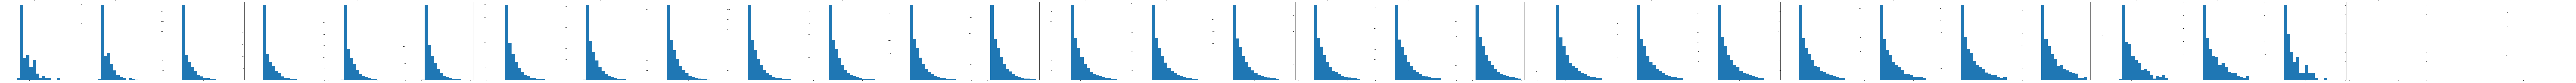

In [39]:
data=np.zeros((1,6,6,4))
with h5py.File("../mk_all_old.h5",'r') as f:
    mk_all=list(f.keys())[:-3]
    n=len(mk_all)
    fig,axis=plt.subplots(1,n,figsize=(20*n,20))
    print(mk_all)
    k=0
    for path_mk in mk_all:
        data_one=f[path_mk]['pr-3']['dt'][:,:,:,3:7]
        mask = data_one[:,:,:,3].astype(bool)
        data_one=data_one[mask]
        print(data_one.shape)
        data_one_time=data_one[:,0]
        axis[k].hist(data_one_time,bins=20,range=(-1*1e-6,4*1e-6))
        axis[k].set_title(path_mk)
        k+=1
        

['enbin-2.0-0.0', 'enbin0.0-0.1', 'enbin0.1-0.2', 'enbin0.2-0.3', 'enbin0.3-0.4', 'enbin0.4-0.5', 'enbin0.5-0.6', 'enbin0.6-0.7', 'enbin0.7-0.8', 'enbin0.8-0.9', 'enbin0.9-1.0', 'enbin1.0-1.1', 'enbin1.1-1.2', 'enbin1.2-1.3', 'enbin1.3-1.4', 'enbin1.4-1.5', 'enbin1.5-1.6', 'enbin1.6-1.7', 'enbin1.7-1.8', 'enbin1.8-1.9', 'enbin1.9-2.0', 'enbin2.0-2.1', 'enbin2.1-2.2', 'enbin2.2-2.3', 'enbin2.3-2.4', 'enbin2.4-2.5', 'enbin2.5-2.6', 'enbin2.6-2.7', 'enbin2.7-2.8', 'enbin2.8-2.9', 'enbin2.9-3.0', 'enbin3.0-4']
(79, 4)
(450, 4)
(4084, 4)
(13821, 4)
(30749, 4)
(55214, 4)
(79183, 4)
(98875, 4)
(107285, 4)
(108997, 4)
(98930, 4)
(86831, 4)
(75471, 4)
(61342, 4)
(51128, 4)
(41157, 4)
(31501, 4)
(24855, 4)
(18074, 4)
(14806, 4)
(11690, 4)
(7330, 4)
(5629, 4)
(3779, 4)
(2366, 4)
(1253, 4)
(627, 4)
(451, 4)
(99, 4)
(17, 4)
(68, 4)
(0, 4)


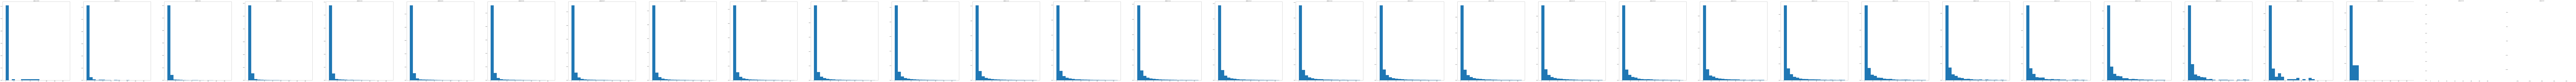

In [44]:
data=np.zeros((1,6,6,4))
with h5py.File("../mk_all_old.h5",'r') as f:
    mk_all=list(f.keys())[:-3]
    n=len(mk_all)
    fig,axis=plt.subplots(1,n,figsize=(20*n,20))
    print(mk_all)
    k=0
    for path_mk in mk_all:
        data_one=f[path_mk]['pr-3']['dt'][:,:,:,3:7]
        mask = data_one[:,:,:,3].astype(bool)
        data_one=data_one[mask]
        print(data_one.shape)
        data_one_time=data_one[:,0]
        axis[k].hist(data_one_time,bins=20,range=(0,150),density=True)
        axis[k].set_title(path_mk)
        k+=1

In [16]:
with h5py.File("../mk_all_old.h5",'r') as f:
#     print(list(f.keys()))
    
    print(f['sddata'].keys())
    print(f['sddata']['dt'])# вырезки центрированные около середины ливня size 6x6
    data=f['sddata']['dt'][:,:,:,3:7]
    print(f['sddata']['ev_params'][:,1])
#     data=f['sddata']['wf_fl'][:]
    print(f['norm_param_global_18.0_qgs3_all']['wf_fl']['mean'][:])
norm_params=norming(data)
print(norm_params)
print(data.shape)
shape=data.shape[1:]

<KeysViewHDF5 ['dt', 'dt_fl', 'ev_params', 'gp', 'mask_fl', 'wf_fl', 'wf_max']>
<HDF5 dataset "dt": shape (21951, 6, 6, 8), type "<f4">
[  0.    190.784 261.837 ... 247.871 144.291 195.698]
[0.12382405 0.12471041]
6.0976224 0.0
1.1657e-05 -1.1702e-05
1.0152e-05 -1.924e-06
1.0 0.0
{'signal': array([6.0976224, 0.       ], dtype=float32), 'pl_fr': array([ 1.1657e-05, -1.1702e-05], dtype=float32), 'real_wf': array([ 1.0152e-05, -1.9240e-06], dtype=float32), 'mask': array([1., 0.], dtype=float32)}
(21951, 6, 6, 4)


In [14]:
dir_name="deep_5___mk_all"
if os.path.exists(dir_name):
    print("\n THIS DIR ALREADY EXISTS \n ALL FILES WILL BE DELETED \n YOU REALY WANT TITH ")
#     time.sleep(10)
else:
    os.mkdir(dir_name)
    os.mkdir('{}/save_images'.format(dir_name))
    os.mkdir('{}/save_model'.format(dir_name))

In [15]:
shape

(6, 6, 4)

In [23]:
noise_dim=50
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0, beta_2=0.9)

In [24]:
def im_one(i,data,axs):
    labels=data[i,:,:,0]
    sns.heatmap(data[i,:,:,2],annot=labels,ax=axs[i,0],vmin=0.0, vmax=1.0)
    sns.heatmap(data[i,:,:,2]-data[i,:,:,1],annot=data[i,:,:,3],ax=axs[i,1],vmin=-1.0, vmax=1.0)

def image_signal(data,fake=None,dir_name=None,ep='not_ep'):
    n=data.shape[0]
    if (fake is None):
        fig, axs = plt.subplots(nrows=n, ncols=2, figsize=(10,n*5))
#         Parallel(n_jobs=-1)(delayed(im_one)(i,data,axs) for i in range(n))
        for i in range(n):
            im_one(i,data,axs)
                           
        fig.suptitle('only real')
    else:
        fig, axs = plt.subplots(nrows=n, ncols=4, figsize=(10*2,n*5))
        for i in range(n):
            
            
            data_after=renormin(np.array([data[i,:,:,:]]),norm_params)
            data_after[0]=tf.where(tf.cast(tf.expand_dims(data_after[0,:,:,-1],axis=-1),tf.bool),data_after[0,:,:,:],np.nan)
            sns.heatmap(data_after[0,:,:,0],annot=data_after[0,:,:,0],ax=axs[i,2],fmt=".1f")
            sns.heatmap(data_after[0,:,:,1],annot=data_after[0,:,:,2],ax=axs[i,3],fmt=".2f")
            
            #fake
            threshold=0.5
            mask_round=tf.where(fake[i,:,:,3]>threshold,1.0,0.0)
            mask_round=tf.cast(mask_round,tf.float32)
            fake_after_mask=np.array([fake[i]])
            #renorming
            
            
            fake_after_renorming=renormin(fake_after_mask,norm_params)
            fake_after_mask=tf.where(tf.cast(tf.expand_dims(mask_round,axis=-1),tf.bool),fake_after_renorming[0,:,:,:],np.nan)# nan

            
            fake_after_mask=fake_after_mask.numpy()
            fake_after_mask[:,:,-1]=mask_round
            fake_after_mask[:,:,-1]=np.where(mask_round<0.9,np.nan,1)
            sns.heatmap(fake_after_mask[:,:,0],annot=fake_after_mask[:,:,0],ax=axs[i,0],fmt=".1f")
            
            sns.heatmap(fake_after_mask[:,:,1],annot=fake_after_mask[:,:,2],ax=axs[i,1],fmt=".2f")
        fig.suptitle('fake     /    real')
    if dir_name:
        plt.savefig("{}/save_images/epoch{}.png".format(dir_name,ep))
        plt.close()
        
def images(generator,num=10,data=data,noise_dim=noise_dim,dir_name='',ep='not_ep'):
    rand=np.random.choice(np.arange(data.shape[0]),num)
    data_for_plot=np.zeros((num,shape[0],shape[1],shape[2]))
    for i in range(num):
        data_for_plot[i]=data[rand[i]]
    noise = tf.random.normal(shape=(num,noise_dim))
    fake=generator(noise)
    image_signal(data_for_plot,fake=fake,dir_name=dir_name,ep=ep)
    

In [25]:
# def stat1(data):
#     time=data[:,:,:,2]
#     # print(time[1])
#     time=tf.where(data[:,:,:,3]==0,np.inf,data[:,:,:,2])
    
#     min_time=tf.math.reduce_min(time,axis=1)
#     min_time=tf.math.reduce_min(min_time,axis=1)
# #     min_time=tf.math.reduce_max(data[:,:,:,0],axis=1)
# #     min_time=tf.math.reduce_max(min_time,axis=1)
#     std_time=np.zeros_like(min_time)
#     time=tf.where(data[:,:,:,3]==0,np.nan,data[:,:,:,2])
#     # убрать цикл. суммирование по оси
#     for i in tqdm.tqdm(range(data.shape[0])):
#         num=tf.reduce_sum(tf.where(tf.math.is_nan(time[i]),0,1))
#         num=tf.cast(num,tf.float32)
#     #     print(tf.reduce_sum(tf.where(tf.math.is_nan(time[i]),0,tf.math.pow(time[i],2))))

#         sum2=tf.reduce_sum(tf.where(tf.math.is_nan(time[i]),0,tf.math.pow(time[i],2)))/num # E(X^2)
#         sum_2=tf.math.pow(tf.reduce_sum(tf.where(tf.math.is_nan(time[i]),0,time[i]))/num,2) #E(X)^2
#     #     print(tf.math.pow((sum2-sum_2),0.5))
#         std_time[i]=tf.math.pow((sum2-sum_2),0.5)
#     return(min_time,std_time)



In [26]:
# ep=199
generator=tf.keras.models.load_model('deep_5/save_model/generator/ep'+str(0))
discriminator=tf.keras.models.load_model('deep_5/save_model/discriminator/ep'+str(0))
# noise = tf.random.normal(shape=(100,50))
# fake_data=generator(noise)#change
# print(tf.math.reduce_mean(discriminator(fake_data)))

# print(tf.math.reduce_mean(discriminator(data[-100:])))

In [22]:
def Generator_model(num="",noise_dim=100): 
    input_tensor=tf.keras.Input(shape=(noise_dim,))
    
    x=tf.keras.layers.Dense(units=25*64,use_bias=False)(input_tensor)
#     x=tf.keras.layers.Dropout(rate=0.1)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.activations.gelu(x)
    x=tf.keras.layers.Reshape((5,5,64))(x)
    
    x=tf.keras.layers.Conv2D(64, (2,2), strides=(1,1), padding='same', use_bias=False,data_format='channels_last',
                            name='C_0')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.activations.gelu(x)
    
    x=tf.keras.layers.Conv2D(64, (2,2), strides=(1,1), padding='same', use_bias=False,data_format='channels_last',
                            name='C_1')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.activations.gelu(x)
    
    
    ## 6x6
    x=tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same', use_bias=False,data_format='channels_last',
                            name='T_1')(x)
#     x=tf.keras.layers.Dropout(rate=0.1)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.activations.gelu(x)
    
    # 12#12
    x=tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same', use_bias=False,data_format='channels_last',
                            name='T_2')(x)
#     x=tf.keras.layers.Dropout(rate=0.1)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.activations.gelu(x)
    
    x=tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same', use_bias=False,data_format='channels_last',
                            name='T_3')(x)
    x=tf.keras.layers.AveragePooling2D((2,2),padding='same')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.activations.gelu(x)
    
    x=tf.keras.layers.Conv2D(16, (2,2), strides=(1,1), padding='same', use_bias=False,data_format='channels_last',
                            name='c_2')(x)
#     x=tf.keras.layers.Dropout(rate=0.1)(x)
    x=tf.keras.layers.AveragePooling2D((2,2),padding='same')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.activations.gelu(x)
# #     print(x.shape)


    x=tf.keras.layers.Conv2D(4, (2,2), strides=(1,1), padding='same', use_bias=False,data_format='channels_last',
                            name='C_3')(x)
    x=tf.keras.activations.sigmoid(x)
    x=tf.keras.layers.Cropping2D((2,2))(x)

    model= tf.keras.Model(input_tensor,x,name="Generator_model_{}".format(num))
    return model
generator=Generator_model(noise_dim=noise_dim)
generator.summary()

Model: "Generator_model_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense (Dense)                (None, 1600)              80000     
_________________________________________________________________
batch_normalization (BatchNo (None, 1600)              6400      
_________________________________________________________________
tf.nn.gelu (TFOpLambda)      (None, 1600)              0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 64)          0         
_________________________________________________________________
C_0 (Conv2D)                 (None, 5, 5, 64)          16384     
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 64)     

In [23]:
def Discriminator_model(num=''):
    input_tensor=tf.keras.Input(shape=shape)
    x= input_tensor
    x=tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=(1), padding='same',name="first")(x)
    x=tf.keras.activations.gelu(x)
    
    x=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same',name="second")(x)
    x=tf.keras.activations.gelu(x)
#     x=tf.keras.layers.AveragePooling2D((2,2),padding='same')(x)
    
    
    # ПОПРОБОВАТЬ Ч1
    
    # mask=tf.keras.layers.MaxPool2D(2)(mask)
    
    
    x=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1), padding='same',name="therd")(x)
    x=tf.keras.activations.gelu(x)
#     x=tf.keras.layers.AveragePooling2D((2,2),padding='same')(x)
    
    
    x=tf.keras.layers.Conv2D(filters=64, kernel_size=(2,2), strides=(1,1), padding='same',name="forth")(x)
#     x=tf.keras.layers.LeakyReLU()(x)
    x=tf.keras.activations.gelu(x)
    
#     x=tf.keras.layers.Conv2D(filters=32, kernel_size=(2,2), strides=(1,1), padding='same',name="fifth")(x)
# #     x=tf.keras.layers.LeakyReLU()(x)
#     x=tf.keras.activations.gelu(x)
    # Ч2
#     x=x*mask
    
    x=tf.keras.layers.Flatten()(x)
#     x=tf.keras.layers.Dropout(rate=0.1)(x)

    x=tf.keras.layers.Dense(units=30)(x)
    x=tf.keras.activations.gelu(x)
    x=tf.keras.layers.Dense(units=1)(x)
    
    model= tf.keras.Model(input_tensor,x,name="Discriminator_model_num_{}".format(num))
    return model

discriminator=Discriminator_model()

discriminator.summary()

Model: "Discriminator_model_num_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 6, 6, 4)]         0         
_________________________________________________________________
first (Conv2D)               (None, 6, 6, 16)          592       
_________________________________________________________________
tf.nn.gelu_7 (TFOpLambda)    (None, 6, 6, 16)          0         
_________________________________________________________________
second (Conv2D)              (None, 3, 3, 32)          4640      
_________________________________________________________________
tf.nn.gelu_8 (TFOpLambda)    (None, 3, 3, 32)          0         
_________________________________________________________________
therd (Conv2D)               (None, 3, 3, 32)          9248      
_________________________________________________________________
tf.nn.gelu_9 (TFOpLambda)    (None, 3, 3, 

In [24]:
def res_unit(inp,f1):
    z=tf.keras.layers.Conv2D(filters=f1, kernel_size=(3,3), strides=(2,2), padding='same')(inp)
    z=tf.keras.activations.gelu(z)
    z=tf.keras.layers.Conv2D(filters=f1, kernel_size=(3,3), strides=(1,1), padding='same')(z)
    y=tf.keras.layers.Conv2D(filters=f1, kernel_size=(1,1), strides=(2,2), padding='same')(inp)
    res=tf.keras.activations.gelu(z+y)
    return res
    
def Discriminator_model(num=''):
    input_tensor=tf.keras.Input(shape=shape)
    x= input_tensor
    x=tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=(1), padding='same',name="first")(x)
    x=tf.keras.activations.gelu(x)
    
    x=res_unit(x,32)
    
    x=res_unit(x,32)
    
    
    
    x=res_unit(x,64)
#     x=x*mask
    
    x=tf.keras.layers.Flatten()(x)
    x=tf.keras.layers.Dense(units=1)(x)
    
    model= tf.keras.Model(input_tensor,x,name="Discriminator_model_num_{}".format(num))
    return model

discriminator=Discriminator_model()

discriminator.summary()
# tf.keras.utils.plot_model(discriminator)

Model: "Discriminator_model_num_"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 6, 6, 4)]    0                                            
__________________________________________________________________________________________________
first (Conv2D)                  (None, 6, 6, 16)     592         input_3[0][0]                    
__________________________________________________________________________________________________
tf.nn.gelu_12 (TFOpLambda)      (None, 6, 6, 16)     0           first[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 3, 3, 32)     4640        tf.nn.gelu_12[0][0]              
___________________________________________________________________________

In [27]:
def discriminator_loss(real_output, fake_output):
#     real_loss = loss_function(tf.ones_like(real_output), real_output)
#     fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    real_loss = -tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def loss_time(data,kof=10,res=tf.Variable(0,dtype=tf.float32)):
#     res=tf.Variable(0,dtype=tf.float32)
    for i in range(data.shape[0]):
        data_n=tf.where(tf.cast(tf.expand_dims(data[i,:,:,3],axis=-1),tf.bool),data[i],np.nan)
        arg=tf.where(data_n[:,:,0] == tf.math.reduce_max(data[i,:,:,0]))[0]
        time=data_n[arg[0],arg[1],2]
        min_time=tf.math.reduce_min(tf.where(tf.math.is_nan(data_n[:,:,2]),np.inf,data_n[:,:,2]))
        res=res+time-min_time
    return(res/data.shape[0]*kof)
        
#     max_active_time=
def generator_loss(fake_output):
#     return loss_function(tf.ones_like(fake_output), fake_output)
    return -tf.reduce_mean(fake_output)

def gradient_penalti(batch,real_data,fake_data):
#   alpha = tf.random.normal([batch, 1], 0.0, 1.0)
#   diff = fake_data - real_data
#   interpolated = real_data + alpha * diff
    epsilon=tf.random.uniform(shape=(batch,1,1,1),dtype=tf.dtypes.float32)
#     print(epsilon)
    interpolated=real_data-epsilon*(real_data-fake_data)# вычисление x^ как в статье
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred=discriminator(interpolated,training=True)  # D(x^)
    grads = gp_tape.gradient(pred, [interpolated])[0]# because list
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp    
@tf.function
def train_step_WGAN(labda,batch,real_data,weight_gp,weight_corr):
  # labda --> number learling critic
  #weight --> weight gradient_penalti

  #learning critic
    for i in range(labda):
        with tf.GradientTape() as gr:
            noise = tf.random.normal(shape=(batch,noise_dim))
            fake_data=generator(noise)#change
#             print('f')
            real_data=real_data
            fake_predict=discriminator(fake_data)
            real_predict=discriminator(real_data)
            real_data=tf.cast(real_data,dtype=tf.float32)
            gp=gradient_penalti(batch,real_data,fake_data)
            disc_loss=discriminator_loss(real_predict,fake_predict)+weight_gp*gp # critic loss include GP
        d_grad=gr.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(d_grad, discriminator.trainable_variables))
  #learning generator
    noise = tf.random.normal(shape=(batch,noise_dim))
    with tf.GradientTape() as gr:
        fake_data=generator(noise)
        fake_predict=discriminator(fake_data)
#         corr_loss=correletion_loss(fake_data)
        gen_loss=generator_loss(fake_predict)
        gen_loss=gen_loss+ loss_time(fake_data)
    g_grad=gr.gradient(gen_loss,generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(g_grad, generator.trainable_variables))
    return (gen_loss,disc_loss,loss_time(fake_data))
def func_chunks_generators(lst, n):
    '''передается масив и число.масив разбивается на масивы длиной не более n
    пример func_chunks_generators([1,2,3,4,5], 3) -> [[1,2,3],[4,5]]
    lst- масив
    n- число, пределяющее максимальную длину'''
    l=[]
    for i in range(0, len(lst), n):
         l.append(lst[i : i + n])
    return(l)

In [ ]:
batch=64
epochs=230
ep_start=0
g_list=[]
d_list=[]
time_list=[]
def train_WGAN(epochs,train_data,batch):
    plt.figure()
    train_data=func_chunks_generators(train_data, batch)
    for j in tqdm_notebook(range(ep_start,epochs),'ep'):
        for num in range(0,len(train_data)):
            step_data=train_data[num]
            g,d,t=train_step_WGAN(labda=5,batch=len(step_data),real_data=step_data,weight_gp=10,weight_corr=1)
            d_list.append(d)
            g_list.append(g)
            time_list.append(t)
        if (j % 10 == 0):
            images(generator,num=10,noise_dim=noise_dim,dir_name=dir_name,ep=j)
            discriminator.save("{}/save_model/discriminator/ep{}".format(dir_name,j))
            generator.save("{}/save_model/generator/ep{}".format(dir_name,j))
            plt.close()

train_WGAN(epochs,data,batch)
plt.close()
plt.figure()
plt.plot(d_list[5000::100],'r')
plt.plot(g_list[5000::100],'g')
plt.plot(time_list[5000::100],'b')
plt.legend(['disc','gen'])
# plt.ylim(-5,5)
plt.title(dir_name)
plt.savefig(os.path.join(dir_name,'loss.jpg'))
df=pd.DataFrame({'disc':d_list,'gen':g_list,"time":time_list})
df.to_csv("{}/loss.csv".format(dir_name))

INFO:tensorflow:Assets written to: deep_5___mk_all/save_model/discriminator/ep0/assets
INFO:tensorflow:Assets written to: deep_5___mk_all/save_model/generator/ep0/assets


Text(0.5, 1.0, 'deep_5_loss+')

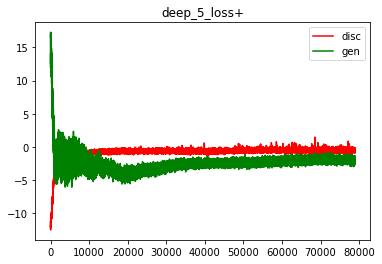

In [44]:
plt.figure()
plt.plot(d_list,'r')
plt.plot(g_list,'g')
# plt.plot(time_list[5000::100],'b')
plt.legend(['disc','gen','time'])
# plt.ylim(-5,5)
plt.title(dir_name)
# plt.savefig(os.path.join(dir_name,'loss.jpg'))

In [41]:
df=pd.DataFrame({'disc':d_list,'gen':g_list,"time":time_list})
df.to_csv("{}/loss.csv".format(dir_name))

Text(0.5, 1.0, 'deep_5_+loss')

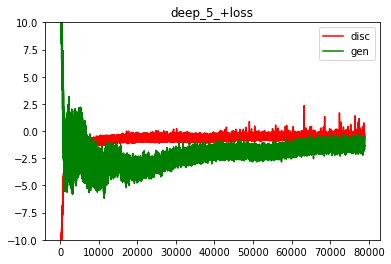

In [45]:
plt.plot(d_list,'r')
plt.plot(g_list,'g')
plt.legend(['disc','gen'])
plt.ylim(-10,10)
plt.title(dir_name)
# plt.savefig(os.path.join('deep_7_2','loss.jpg'))

Text(0.5, 1.0, 'deep_res')

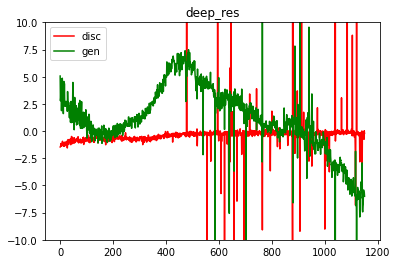

In [45]:
plt.plot(d_list[5000::100],'r')
plt.plot(g_list[5000::100],'g')
plt.legend(['disc','gen'])
plt.ylim(-10,10)
plt.title(dir_name)
# plt.savefig(os.path.join('deep_7_2','loss.jpg'))

Text(0.5, 1.0, 'deep_7')

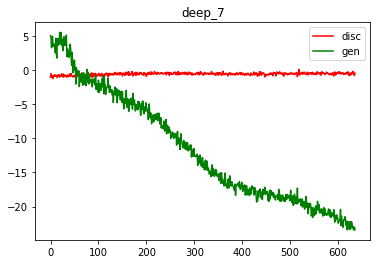

In [25]:
plt.plot(d_list[5000::100],'r')
plt.plot(g_list[5000::100],'g')
plt.legend(['disc','gen'])
# plt.ylim(-5,5)
plt.title(dir_name)

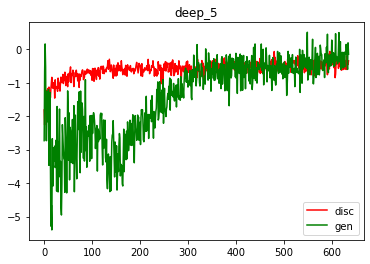

In [27]:
plt.plot(d_list[5000::100],'r')
plt.plot(g_list[5000::100],'g')
plt.legend(['disc','gen'])
# plt.ylim(-5,5)
plt.title(dir_name)
plt.savefig(os.path.join(dir_name,'loss.jpg'))

  0%|          | 8/3000 [00:00<01:36, 30.86it/s]


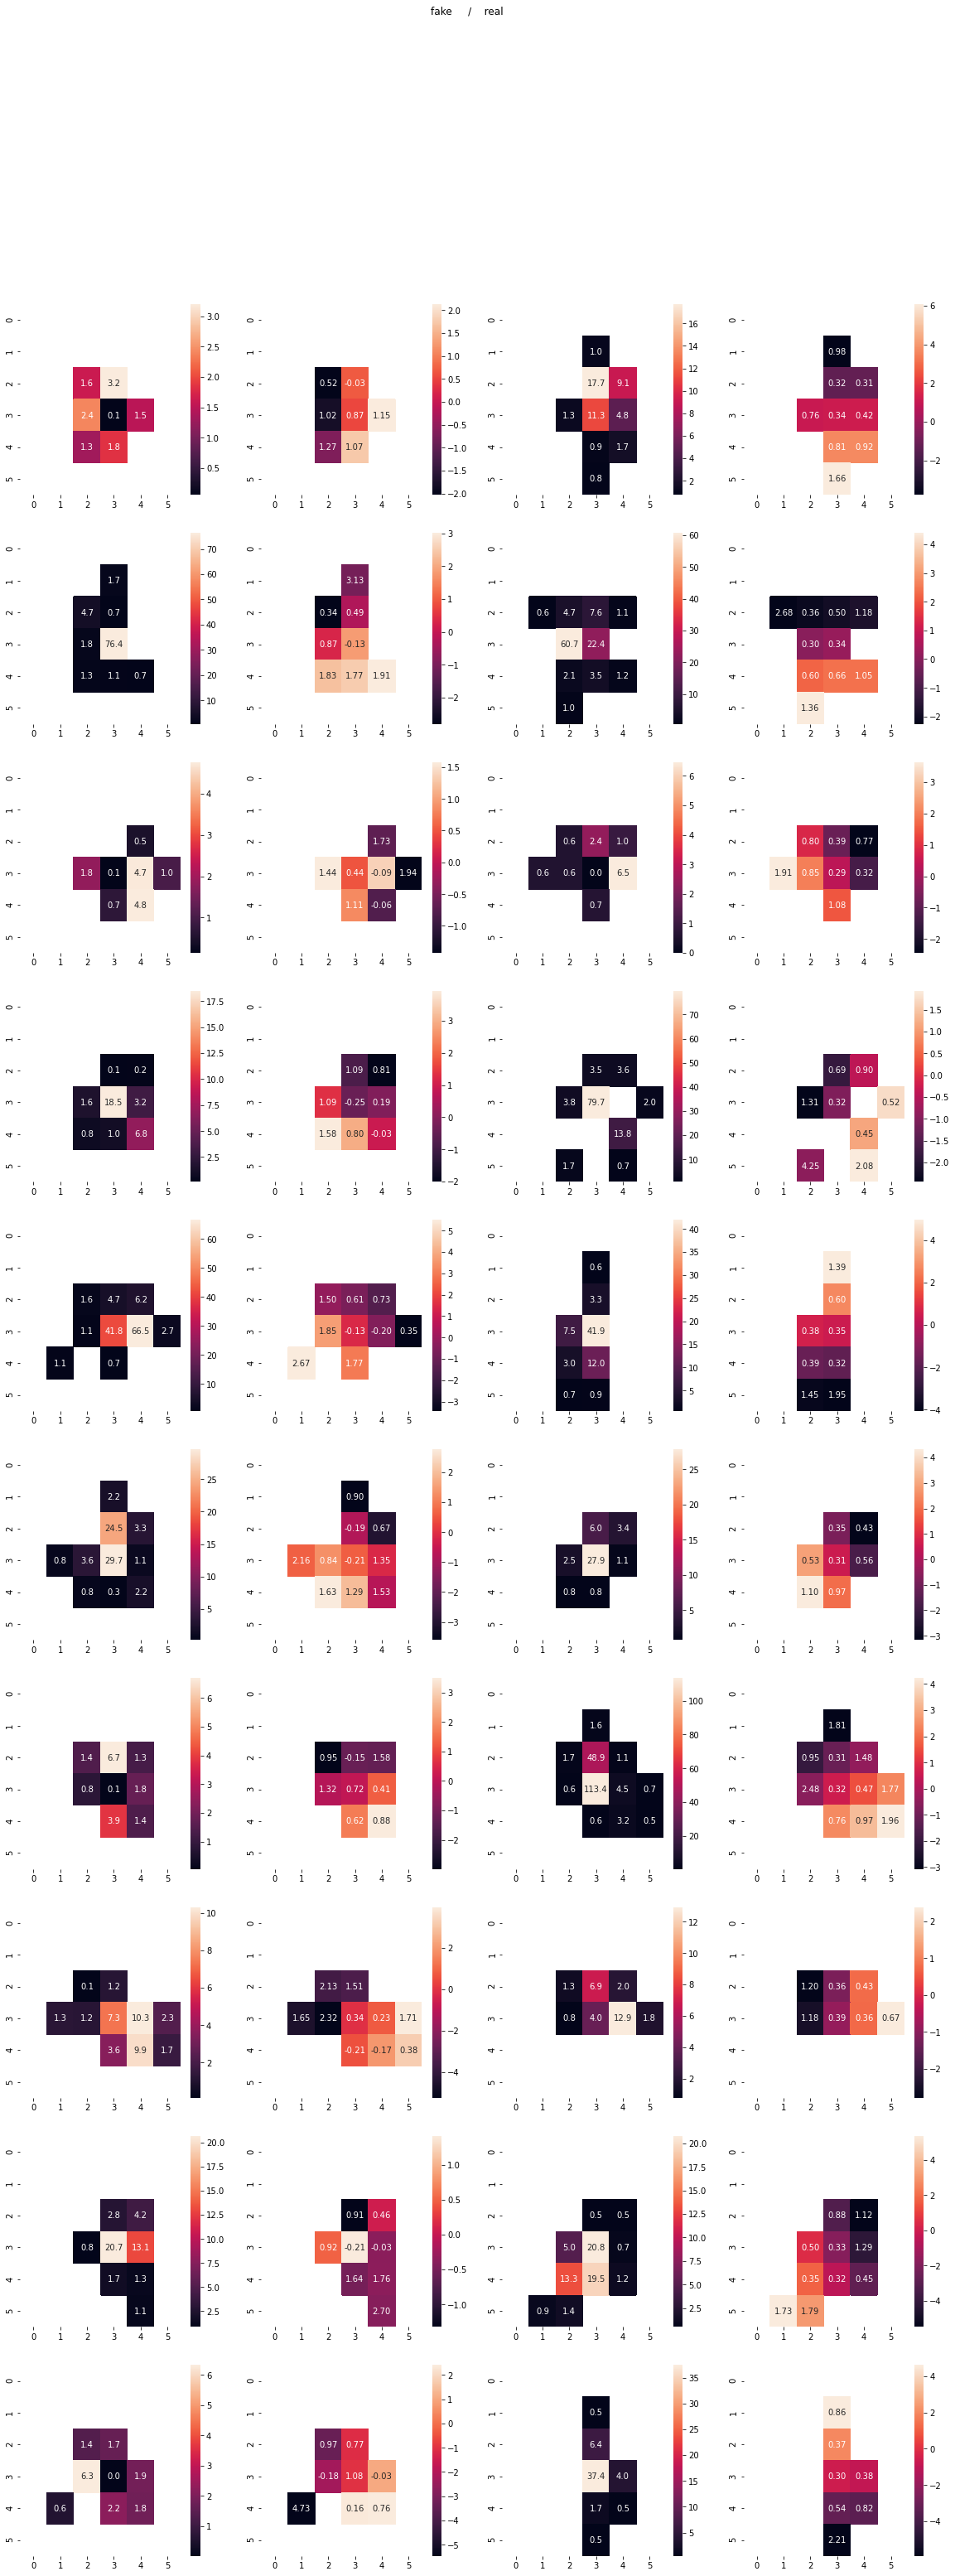

In [30]:
ep=199
generator=tf.keras.models.load_model('deep_5/save_model/generator/ep'+str(ep))
discriminator=tf.keras.models.load_model('deep_5/save_model/discriminator/ep'+str(ep))
def Residual_loss(data_true, data_fake):
    return tf.reduce_mean( tf.math.abs(data_true - data_fake),axis=(1,2,3))# сделать универсально
def Discriminator_loss(data_true, data_fake,discriminator):
    real_pred=discriminator(data_true)
    fake_pred=discriminator(data_fake)
    return tf.math.abs( real_pred - fake_pred)
loss_L=[]
def find_noise(generator,discriminator,image,noise_dim,alpha=1.2,k_rd=0.0001):
#         global loss_L
#     print(image.sha)
    global loss_L
    loss_befor=1000000000
    k=0
    noise = tf.random.normal(shape=(image.shape[0],noise_dim))
    noise_befor=tf.identity(noise)
    for i in tqdm.tqdm(range(3000)):
        with tf.GradientTape() as tape:
            tape.watch(noise)
            fake=generator(noise)
            loss=Residual_loss(image, fake)
            loss_disc=Discriminator_loss(image, fake,discriminator)*k_rd
            Loss=tf.reshape(loss,(-1,1))+loss_disc
            loss_L.append(Loss)
        g_grad=tape.gradient(Loss,noise)
        noise=noise-alpha*g_grad
        if tf.math.reduce_mean((loss_befor-Loss))<0.005*tf.math.reduce_mean(Loss):
            k+=1
            if k>7:
                break
        else:
            loss_befor=Loss
            k=0
            
    return (noise,noise_befor)
def images_define(generator,num=10,data=data,noise_dim=noise_dim,dir_name='',ep='not_ep'):
    rand=np.random.choice(np.arange(data.shape[0]),num)
    data_for_plot=np.zeros((num,shape[0],shape[1],shape[2]))
    fake=np.zeros((num,shape[0],shape[1],shape[2]))
    for i in range(num):
        data_for_plot[i]=data[rand[i]]
        noise = find_noise(generator,discriminator,np.array([data_for_plot[i]]),noise_dim,alpha=1.2,k_rd=0.0001)[0]
        fake[i]=generator(noise)
    image_signal(data_for_plot,fake=fake,dir_name=dir_name,ep=ep)

images_define(generator,num=10,data=data,noise_dim=noise_dim,dir_name='',ep='not_ep')
